# 데이터 준비

## max_length 계산

SMILES Token Length Statistics:
count    133885.000000
mean         13.157829
std           2.571324
min           3.000000
25%          11.000000
50%          13.000000
75%          15.000000
max          24.000000
Name: token_length, dtype: float64
95%의 SMILES는 17 토큰 이하의 길이를 가집니다.


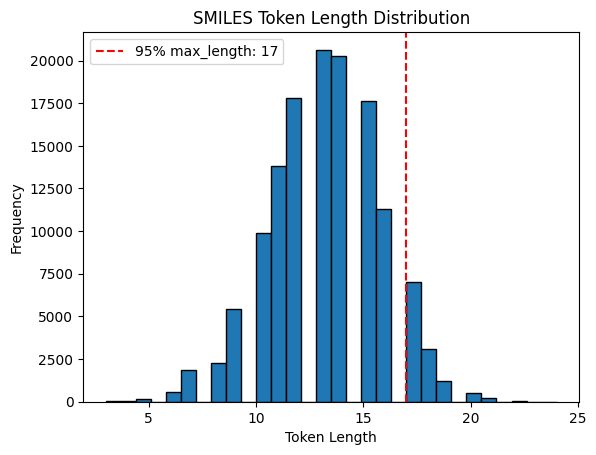

In [ ]:
import pandas as pd
from transformers import RobertaTokenizer

# QM9 데이터셋 로드
file_path = "/content/qm9.csv"
qm9_data = pd.read_csv(file_path)

# ChemBERTa 토크나이저 로드
tokenizer = RobertaTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

# 각 SMILES의 토큰 길이 계산 함수
def calculate_token_length(smiles):
    tokens = tokenizer(smiles, return_tensors="pt", padding=False, truncation=False)
    return len(tokens["input_ids"][0])

# 각 SMILES의 토큰 길이 계산 및 데이터프레임에 추가
qm9_data["token_length"] = qm9_data["smiles"].apply(calculate_token_length)

# 길이 분포 통계 확인
length_stats = qm9_data["token_length"].describe()
print("SMILES Token Length Statistics:")
print(length_stats)

# 95% 백분위수 계산
max_length_95 = int(qm9_data["token_length"].quantile(0.95))
print(f"95%의 SMILES는 {max_length_95} 토큰 이하의 길이를 가집니다.")

# 길이 분포 히스토그램 시각화 (선택적)
import matplotlib.pyplot as plt

plt.hist(qm9_data["token_length"], bins=30, edgecolor="k")
plt.axvline(max_length_95, color="r", linestyle="--", label=f"95% max_length: {max_length_95}")
plt.title("SMILES Token Length Distribution")
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.legend()
plt.show()


## Canonical SMILES 변환


In [3]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 62.7 MB/s eta 0:00:00


In [ ]:
# non Canonical SMILES 비율 확인

from rdkit import Chem
import pandas as pd

# QM9 데이터셋 로드
file_path = "/content/qm9.csv"  # QM9 데이터 파일 경로
qm9_data = pd.read_csv(file_path)

# Canonical SMILES 확인 함수
def is_canonical(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)  # SMILES 문자열을 Mol 객체로 변환
        if mol is None:
            return False  # 변환 실패
        canonical_smiles = Chem.MolToSmiles(mol, canonical=True)  # Canonical SMILES 생성
        return smiles == canonical_smiles  # 원본과 Canonical SMILES 비교
    except Exception as e:
        return False  # 예외 발생 시 False 반환

# Canonical SMILES 여부 확인
qm9_data["is_canonical"] = qm9_data["smiles"].apply(is_canonical)

# 결과 통계
canonical_count = qm9_data["is_canonical"].sum()
non_canonical_count = len(qm9_data) - canonical_count

print(f"Total samples checked: {len(qm9_data)}")
print(f"Canonical SMILES count: {canonical_count}")
print(f"Non-canonical SMILES count: {non_canonical_count}")


Total samples checked: 133885
Canonical SMILES count: 51287
Non-canonical SMILES count: 82598
Non-canonical SMILES samples have been saved to 'non_canonical_smiles.csv'.


In [ ]:
from rdkit import Chem
import pandas as pd

# QM9 데이터셋 로드
qm9_data = pd.read_csv("/content/qm9.csv")

# Canonical SMILES 변환 함수
def convert_to_canonical(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        return Chem.MolToSmiles(mol, canonical=True)
    except Exception:
        return None

# 데이터셋에 Canonical SMILES 적용
qm9_data["canonical_smiles"] = qm9_data["smiles"].apply(convert_to_canonical)

# Canonical SMILES가 None인 데이터 제거
qm9_data = qm9_data.dropna(subset=["canonical_smiles"])

# 확인
print(qm9_data.head())

# Canonical SMILES 데이터셋 저장
qm9_data[["canonical_smiles", "gap"]].to_csv("qm9_canonical.csv", index=False)


  mol_id smiles          A           B           C      mu  alpha    homo  \
0  gdb_1      C  157.71180  157.709970  157.706990  0.0000  13.21 -0.3877   
1  gdb_2      N  293.60975  293.541110  191.393970  1.6256   9.46 -0.2570   
2  gdb_3      O  799.58812  437.903860  282.945450  1.8511   6.31 -0.2928   
3  gdb_4    C#C    0.00000   35.610036   35.610036  0.0000  16.28 -0.2845   
4  gdb_5    C#N    0.00000   44.593883   44.593883  2.8937  12.99 -0.3604   

     lumo     gap  ...         u0       u298       h298       g298     cv  \
0  0.1171  0.5048  ... -40.478930 -40.476062 -40.475117 -40.498597  6.469   
1  0.0829  0.3399  ... -56.525887 -56.523026 -56.522082 -56.544961  6.316   
2  0.0687  0.3615  ... -76.404702 -76.401867 -76.400922 -76.422349  6.002   
3  0.0506  0.3351  ... -77.308427 -77.305527 -77.304583 -77.327429  8.574   
4  0.0191  0.3796  ... -93.411888 -93.409370 -93.408425 -93.431246  6.278   

      u0_atom   u298_atom   h298_atom   g298_atom  canonical_smiles  
0 -3

## train/test dataset 결정

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# QM9 데이터 로드
file_path = "/content/qm9.csv"  # QM9 데이터셋 경로
qm9_data = pd.read_csv(file_path)

# 필요한 열만 추출 (smiles와 gap)
data = qm9_data[['smiles', 'gap']].dropna()

# Train/Test 데이터셋 분리 (90% Train, 10% Test)
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)

# 결과 확인
print(f"Train dataset size: {train_data.shape[0]} rows")
print(f"Test dataset size: {test_data.shape[0]} rows")

# Train/Test 데이터셋 저장
train_data.to_csv("qm9_train.csv", index=False)
test_data.to_csv("qm9_test.csv", index=False)

print("Train/Test datasets have been saved as 'qm9_train.csv' and 'qm9_test.csv'.")

Train dataset size: 120496 rows
Test dataset size: 13389 rows
Train/Test datasets have been saved as 'qm9_train.csv' and 'qm9_test.csv'.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# QM9 Canonical 데이터 로드
file_path = "/content/qm9_canonical.csv"  # QM9 Canonical 데이터셋 경로
qm9_data = pd.read_csv(file_path)

# 필요한 열만 추출 (canonical_smiles와 gap)
data = qm9_data[['canonical_smiles', 'gap']].dropna()

# Train/Test 데이터셋 분리 (90% Train, 10% Test)
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)

# 결과 확인
print(f"Train dataset size: {train_data.shape[0]} rows")
print(f"Test dataset size: {test_data.shape[0]} rows")

# Train/Test 데이터셋 저장
train_data.to_csv("qm9_canonical_train.csv", index=False)
test_data.to_csv("qm9_canonical_test.csv", index=False)

print("Train/Test datasets have been saved as 'qm9_canonical_train.csv' and 'qm9_canonical_test.csv'.")


Train dataset size: 120496 rows
Test dataset size: 13389 rows
Train/Test datasets have been saved as 'qm9_canonical_train.csv' and 'qm9_canonical_test.csv'.


# Training / Testing

## (Non-canonical) SMILES

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import pandas as pd

# 모델 및 토크나이저 로드
model_name = "seyonec/ChemBERTa-zinc-base-v1"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=1)

# 데이터 로드
train_data = pd.read_csv("/content/qm9_train.csv")
test_data = pd.read_csv("/content/qm9_test.csv")

# SMILES 토큰화
class SMILESDataset(Dataset):
    def __init__(self, dataframe, tokenizer, target_col):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.target_col = target_col

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        smiles = self.data.iloc[idx]['smiles']
        target = self.data.iloc[idx][self.target_col]
        tokens = self.tokenizer(smiles, padding='max_length', truncation=True, max_length=20, return_tensors='pt')
        item = {key: val.squeeze(0) for key, val in tokens.items()}
        item['labels'] = torch.tensor(target, dtype=torch.float)
        return item

# 데이터셋 준비
train_dataset = SMILESDataset(train_data, tokenizer, 'gap')
test_dataset = SMILESDataset(test_data, tokenizer, 'gap')

# 데이터 Collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 학습 파라미터
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,  # 배치 크기 축소
    per_device_eval_batch_size=16,
    num_train_epochs=2,  # 에포크 수
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

# Trainer 설정
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
)

# 모델 학습
trainer.train()

# 모델 저장
model.save_pretrained("./jjh/ChemBERTa-smiles-gap")
tokenizer.save_pretrained("./jjh/ChemBERTa-smiles-gap")

print("파인튜닝 완료 및 모델 저장 완료!")

# 테스트 데이터 평가
evaluation_results = trainer.evaluate()
print("테스트 데이터 평가 결과:", evaluation_results)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,0.000800,0.000521
2,0.000300,0.000344


파인튜닝 완료 및 모델 저장 완료!


테스트 데이터 평가 결과: {'eval_loss': 0.000344324012985453, 'eval_runtime': 557.5386, 'eval_samples_per_second': 24.014, 'eval_steps_per_second': 1.501, 'epoch': 2.0}


## Canonical SMILES


In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import pandas as pd

# 모델 및 토크나이저 로드
model_name = "seyonec/ChemBERTa-zinc-base-v1"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=1)

# 데이터 로드
train_data = pd.read_csv("/content/qm9_canonical_train.csv")
test_data = pd.read_csv("/content/qm9_canonical_test.csv")

# SMILES 토큰화
class SMILESDataset(Dataset):
    def __init__(self, dataframe, tokenizer, target_col):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.target_col = target_col

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        smiles = self.data.iloc[idx]['canonical_smiles']
        target = self.data.iloc[idx][self.target_col]
        tokens = self.tokenizer(smiles, padding='max_length', truncation=True, max_length=20, return_tensors='pt')
        item = {key: val.squeeze(0) for key, val in tokens.items()}
        item['labels'] = torch.tensor(target, dtype=torch.float)
        return item

# 데이터셋 준비 (전체 데이터 사용)
train_dataset = SMILESDataset(train_data, tokenizer, 'gap')
test_dataset = SMILESDataset(test_data, tokenizer, 'gap')

# 데이터 Collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 학습 파라미터
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,  # 배치 크기
    per_device_eval_batch_size=16,
    num_train_epochs=2,  # 에포크 수
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

# Trainer 설정
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
)

# 모델 학습
trainer.train()

# 모델 저장
model.save_pretrained("./jjh/ChemBERTa-canonical_smiles-gap")
tokenizer.save_pretrained("./jjh/ChemBERTa-canonical_smiles-gap")

print("파인튜닝 완료 및 모델 저장 완료!")

# 테스트 데이터 평가
evaluation_results = trainer.evaluate()
print("테스트 데이터 평가 결과:", evaluation_results)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,0.001000,0.001319
2,0.000400,0.000296


파인튜닝 완료 및 모델 저장 완료!


테스트 데이터 평가 결과: {'eval_loss': 0.0002959519624710083, 'eval_runtime': 483.0734, 'eval_samples_per_second': 27.716, 'eval_steps_per_second': 1.733, 'epoch': 2.0}


# 기타 코드


In [4]:
!apt-get install fonts-nanum -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (5,626 kB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 123632 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [9]:
from graphviz import Digraph

# Create a directed graph
flowchart = Digraph(format='png', engine='dot')

# 한글 폰트 설정 (Colab 환경에서는 "NanumGothic" 폰트 설치 필요)
flowchart.attr(fontname="NanumGothic")
flowchart.node_attr.update(fontname="NanumGothic")

# 데이터 준비 단계
flowchart.node("A", "QM9 데이터셋 준비")
flowchart.node("B1", "Tokenizer로\n토큰 길이 확인\n(max token length 계산)", shape="box")
flowchart.node("B2", "Rdkit으로\nCanonical SMILES 변환\n및 비-Canonical 개수 계산", shape="box")
flowchart.node("B3", "Training/Test\nDataset 분리", shape="box")

# Fine tuning 단계
flowchart.node("C", "ChemBERTa 모델 fine-tuning 준비 완료")
flowchart.node("D1", "SMILES Dataset 학습", shape="box")
flowchart.node("D2", "Canonical SMILES\nDataset 학습", shape="box")

# 성능 확인 단계
flowchart.node("E", "MSE를 사용한\n성능 비교")
flowchart.node("F", "SMILES vs Canonical SMILES\n예측 성능 분석")

# 데이터 준비 단계 연결 (병렬 가로 배치)
flowchart.edge("A", "B1", constraint="false")
flowchart.edge("A", "B2", constraint="false")
flowchart.edge("A", "B3", constraint="false")

# Fine tuning 단계 연결
flowchart.edge("B1", "C", constraint="true")
flowchart.edge("B2", "C", constraint="true")
flowchart.edge("B3", "C", constraint="true")
flowchart.edge("C", "D1")
flowchart.edge("C", "D2")

# 성능 확인 단계 연결
flowchart.edge("D1", "E")
flowchart.edge("D2", "E")
flowchart.edge("E", "F")

# Save and render the flowchart
flowchart.render("model_workflow_parallel", cleanup=True)

print("Flowchart saved as 'model_workflow_parallel.png'")


Flowchart saved as 'model_workflow_parallel.png'


In [5]:
!pip freeze > requirements.txt


In [1]:
!nvidia-smi

Sun Dec  8 08:04:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
!cat /proc/cpuinfo | grep 'model name' | uniq


model name	: Intel(R) Xeon(R) CPU @ 2.00GHz


In [12]:
import sys
import torch

print("Python version:", sys.version)
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA version:", torch.version.cuda)
    print("Device name:", torch.cuda.get_device_name(0))

Python version: 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
PyTorch version: 2.5.1+cu121
CUDA available: False


In [4]:
!lsb_release -a


No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.3 LTS
Release:	22.04
Codename:	jammy
